#  TITLE TUTORIAL - date 

Pedro Di Nezio (pdn@utig.ig.utexas.edu)



The latest version of this [IPython notebook](http://ipython.org/notebook.html) tutorial is available at
<font color='blue'>Github adress</font>.



## 1. Introduction

Understand how to use a Heat budget to compare ENSO. Example bar for 0ka and 21ka and then study of feedback directly using the NDO.


This is the introduction, we are going to bla balabalala la
* first we gonna 
    * then a second point ert 
    
Every body is _happy_, we __goonna rock__ that shit 


http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

In [21]:
# Import necessary modules 
import numpy as np
import scipy.io

# Modules used for the exponential fits 
from scipy.optimize import curve_fit
import pandas as pd

# Defaultdict
from collections import defaultdict

# Plots attributes 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from datetime import datetime

# Correlogram PSD function 
from spectrum import *

# Generate random skewed noise 
from scipy.stats import skewnorm

# Seaborn for distributions plots.
import seaborn as sns
sns.reset_orig()

# Stat modules 
from scipy.stats import skew
from scipy import stats
from scipy.interpolate import interp1d

# Solver 
from scipy.optimize import fsolve

# Miscellaneous 
from IPython.display import display,HTML
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

In [22]:
# Choose the case here (0ka, 12ka, 2xco2, 15ka etc.)
CASE='0ka'

In [23]:
# Load the heat budget file including Mixed layer tendencies and various variables averaged in Niño3.4 region. 
heat_budget=np.load('Heat_budget_'+CASE+'.npy').item()

## 2. The Non-linear delayed oscillator

In Niño3.4 region, where air-sea interactions are strong, ENSO can be reduced to a simple conceptual model such as the Non-linear Delayed Oscillator (NDO). Under this framework, temporal variations of SST anomalies in this region can be decomposed into as a sum of positive and negative feedback as follow: 

<br>

$$ \frac{\partial T'(t)}{\partial t} = aT'(t) -bT'(t-t_0)-cT'(t)-dT'(t)+N(t)  \;\;\;\;      (1)$$
<br>
           
Where __a__ represents the positive Bjerknes feedback, __b__ the negative delayed thermocline feedback with $t_{0}$ corresponding to the lag at which the anticorrelation between thermocline anomalies and T' is maximum, __c__ the atmospheric damping, __d__ non-linear damping and __N(t)__ some white Gaussian noise.
<br>
<br>

#### 2.1 Computation of the feedback a,b,c and d

In opposition to the classical Delayed Oscillator (Suarez and Schopf 1988), wherein the coefficient __a,b,c__ and __d__ are  constant, here they are nonlinear functions of $T'(t)$ or $T'(t-t_{0})$ and calendar month.

<br>

We derive these functions by fitting the terms of the heat budget __(Q)__ to the functions of the following forms:
<br>
<br>

$$Q(T') = C_{1}e^{C_{2}T'(t)}+C_{2} \;\;\;\;\;\; or\;\;\;\;\;\; Q(T')=C_{1}e^{C_{2}T'(t)}+C_{3}e^{C_{4}T'(t-t_{0})}+C_{4}$$
<br>
<br>

Mixed layer heat budget equation :  $$\frac{\partial T'(t)}{\partial t} =\underbrace{u'.\frac{\overline{\partial T}}{\partial x}+\overline{u}.\frac{\partial T'}{\partial x}+v'.\frac{\overline{\partial T}}{\partial y}+\overline{v}.\frac{\partial T'}{\partial y}}_\text{Horizontal advection tendencies}+\underbrace{w'.\frac{\overline{\partial T}}{\partial z}+\overline{w}.\frac{\partial T'}{\partial z}}_\text{Vertical advection tendencies} + \underbrace{\frac{Q_{atm}}{\rho C_{p}H}}_\text{Atm fluxes tendency}$$
<br>
<br>




The only functions exhibiting multiple dependence on $T'$ and $T'(t-t_{0})\;$ are $\; u'.\frac{\overline{\partial T}}{\partial x}\;$ and $\; \overline{w}.\frac{\partial T'}{\partial z}$


In [24]:
# Definition of the exponential functions for the fits and initial guess for the constants 
def exp_f(x, a, b, c):
    return a*np.exp(b*x)+c

def exp_f2(x, a, b, c, d, e):
    return a*np.exp(b*x[0])+c*np.exp(d*x[1])+e

In [25]:
# Initial guess for the constants for the fits. 
if CASE == '0ka':
    lag=5
    N0,ska,skl=0.113,0,0
elif CASE == '12ka':
    lag=5
    N0,ska,skl=0.1,0,0
elif CASE == '15ka':
    lag=5
    N0,ska,skl=0.09,0,0
elif CASE == '21ka':    
    lag=5
    N0,ska,skl=0.11,0,0      
elif CASE == '24ka':    
    lag=5
    N0,ska,skl=0.119,0,0
elif CASE =='2xco2':
    lag=10
    N0,ska,skl=0.32,0,0 

In [26]:
# Initial guess for the constants for the fits. 
cin     = [ 1, 1, -1, 1, 1, 1, 1,1,-1,-1,1,1]

Q=defaultdict(dict) # Dictionnary to stock the fit coefficients 
R=defaultdict(dict)

var_name   = ['qu','qv','qw','qnet','qres']
proc1      = ['_curr','_temp','_nl']
proc2      = ['']

var_t=['tos','tos']

month_ind=np.roll(np.linspace(0,11,12),1)
inc=0 
for vname in var_name:
    
    if vname == 'qnet' or vname == 'qres':
        proc=proc2
        if vname == 'qnet':
            varT=var_t[0]
        else: 
            varT=var_t[1]
    else:
        proc=proc1
        varT=var_t[1]

    for pr in proc: 

        varname=vname+pr 
        coef=np.zeros((12,3))
        coef_r=np.zeros((12))
        print(varname,end=',')
        
        nyr=int(len(heat_budget[varT]))
        var1=np.reshape(heat_budget[varT],(int(nyr/12),12))
        var2=np.reshape(heat_budget[varname],(int(nyr/12),12))

        condition=(varname == 'qw_temp' or varname == 'qu_curr')
        if not condition:

            for month in range(12):
                
                monthi=[int(i) for i in np.roll(month_ind,-month)[1:2]]
                
                xdata=[]
                xdata=np.reshape(var1[:,monthi],(int(nyr/12*1)))
                ydata=np.reshape(var2[:,monthi],(int(nyr/12*1)))
                    
                # Exponential fit 
                popt, pcov = curve_fit(exp_f, xdata, ydata, p0=(cin[inc], 0, 0),maxfev=500000)

                # Computation R**2 of the fit 
                residuals = ydata- exp_f(xdata, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((ydata-np.mean(ydata))**2)
                r_squared = 1 - (ss_res / ss_tot)

                if np.sqrt(r_squared) < 0.5:
                    popt=popt*0
                    
                coef_r[month]=np.sqrt(r_squared)
                coef[month,:]=popt
            R[varname]=coef_r
            Q[varname]=coef 

            #delayed feedback 
        else: 
            coef=np.zeros((12,5))
            for month in range(12): 
                monthi=month
                monthi_lag=int((np.roll(np.linspace(0,11,12),-month+lag))[0])

                if month-lag < 0:  
                    xdata2=np.reshape(var1[0:-1,monthi_lag],(int(nyr/12-1)))
                    xdata1=np.reshape(var1[1::,monthi],(int(nyr/12-1)))
                    ydata=np.reshape(var2[1::,monthi],(int(nyr/12-1)))
                else: 
                    xdata2=np.reshape(var1[0::,monthi_lag],(int(nyr/12)))
                    xdata1=np.reshape(var1[0::,monthi],(int(nyr/12)))
                    ydata=np.reshape(var2[0::,monthi],(int(nyr/12))) 

                xdata=np.stack((xdata1,xdata2),axis=0)

                if varname == 'qu_curr':
                    popt, pcov = curve_fit(exp_f2, xdata, ydata, p0=(cin[inc],0,-cin[inc]*1000,0,0),maxfev=500000)
                if varname == 'qw_temp': 
                    popt, pcov = curve_fit(exp_f2, xdata, ydata, p0=(cin[inc]*1000,0,-cin[inc],0,0),maxfev=500000)

                residuals = ydata- exp_f2(xdata, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((ydata-np.mean(ydata))**2)
                r_squared = 1 - (ss_res / ss_tot)
                        
                if np.sqrt(r_squared) < 0.5:
                    popt=popt*0
                 
                coef_r[month]=np.sqrt(r_squared)
                coef[month,:]=popt

            R[varname]=coef_r        
            Q[varname]=coef 
            
        inc=inc+1
        
# Also save lag and noise coefficient.
Q['lag']=lag   
Q['noise']=[N0,ska,skl]

# Save Coefficient in Matlab format: 
scipy.io.savemat('Coef_exp_fits_'+CASE, Q, appendmat=True,do_compression=True) 

# Save Coefficient in Python format:
np.save('Coef_exp_fits_'+CASE,Q)

qu_curr,qu_temp,qu_nl,qv_curr,qv_temp,qv_nl,qw_curr,qw_temp,qw_nl,qnet,qres,

# PLot fits 

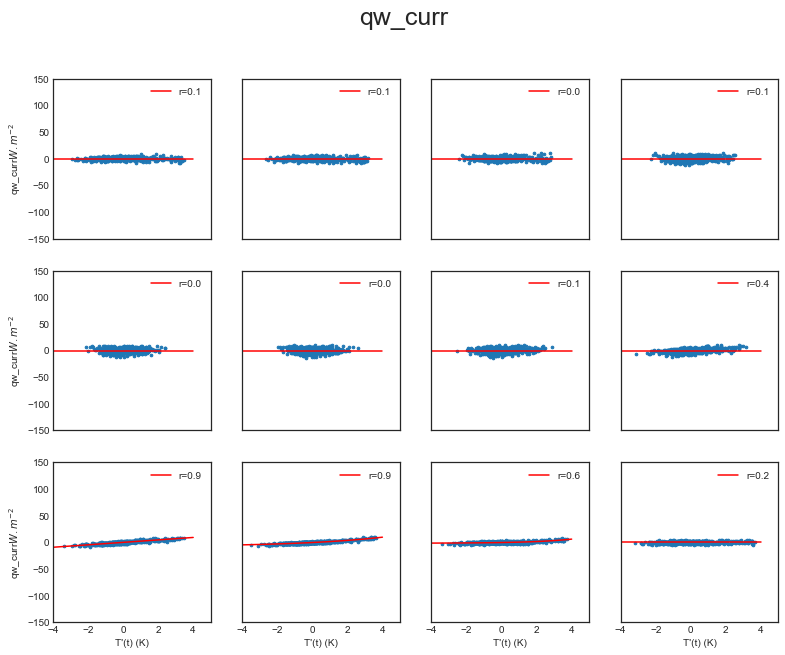

In [41]:
var_plot='qw_curr'

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)

inc=0
for i in range(3):
    for j in range(4):
    
        xdata=np.reshape(heat_budget['tos'],(int(nyr/12),12))[:,inc]
        ydata=np.reshape(heat_budget[var_plot],(int(nyr/12),12))[:,inc]
        
        xx = np.linspace(-4,4,100)
        yy = exp_f(xx, *Q[var_plot][inc,:])
        
        axes[i][j].scatter(xdata,ydata,s=7)
        axes[i][j].plot(xx,yy,color='r',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,5)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

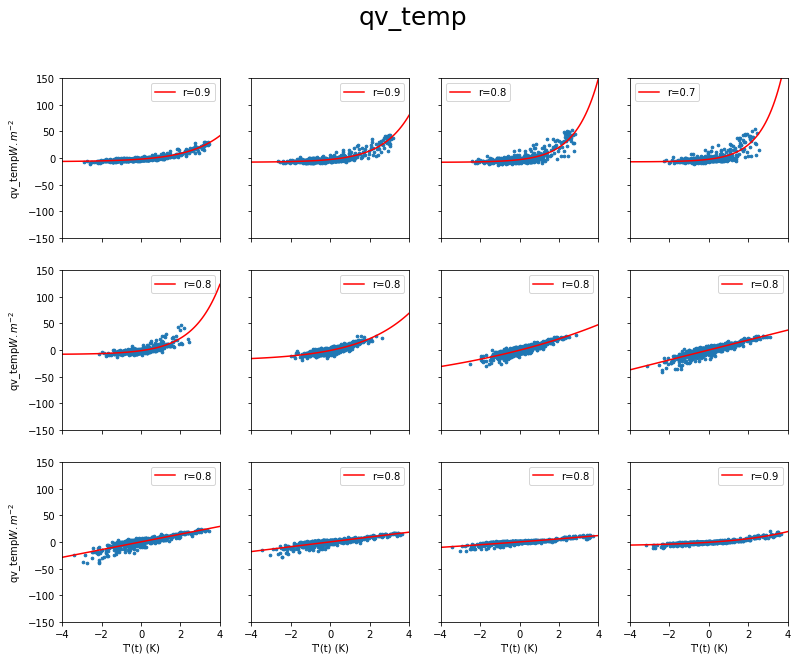

In [28]:
var_plot='qv_temp'

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)

inc=0
for i in range(3):
    for j in range(4):
    
        xdata=np.reshape(heat_budget['tos'],(int(nyr/12),12))[:,inc]
        ydata=np.reshape(heat_budget[var_plot],(int(nyr/12),12))[:,inc]
        
        xx = np.linspace(-4,4,100)
        yy = exp_f(xx, *Q[var_plot][inc,:])
        
        axes[i][j].scatter(xdata,ydata,s=7)
        axes[i][j].plot(xx,yy,color='r',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

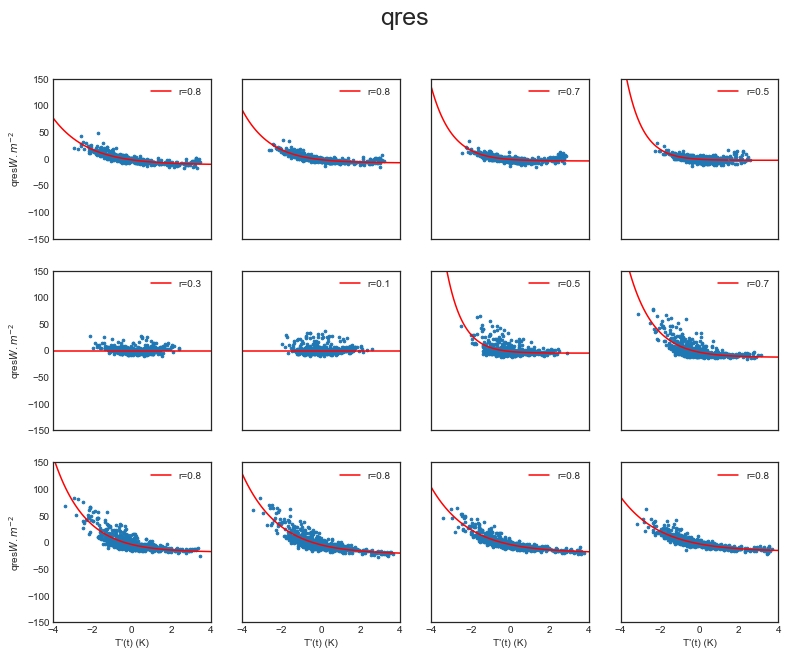

In [46]:
var_plot='qres'

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)

inc=0
for i in range(3):
    for j in range(4):
    
        xdata=np.reshape(heat_budget['tos'],(int(nyr/12),12))[:,inc]
        ydata=np.reshape(heat_budget[var_plot],(int(nyr/12),12))[:,inc]
        
        xx = np.linspace(-4,4,100)
        yy = exp_f(xx, *Q[var_plot][inc,:])
        
        axes[i][j].scatter(xdata,ydata,s=7)
        axes[i][j].plot(xx,yy,color='r',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

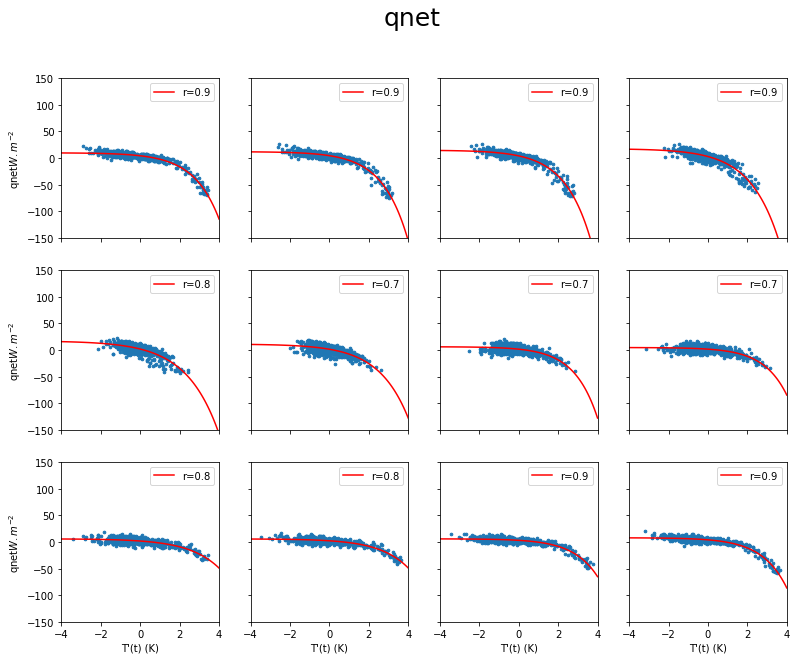

In [30]:
var_plot='qnet'

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)

inc=0
for i in range(3):
    for j in range(4):
    
        xdata=np.reshape(heat_budget['tos'],(int(nyr/12),12))[:,inc]
        ydata=np.reshape(heat_budget[var_plot],(int(nyr/12),12))[:,inc]
        
        xx = np.linspace(-4,4,100)
        yy = exp_f(xx, *Q[var_plot][inc,:])
        
        axes[i][j].scatter(xdata,ydata,s=7)
        axes[i][j].plot(xx,yy,color='r',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

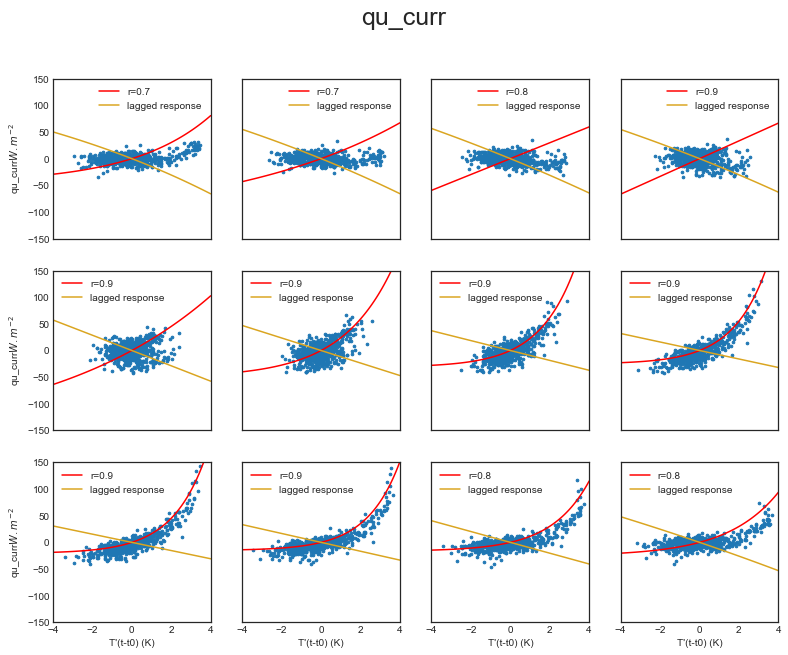

In [43]:
var_plot='qu_curr'

var1=np.reshape(heat_budget['tos'],(int(nyr/12),12))
var2=np.reshape(heat_budget[var_plot],(int(nyr/12),12))

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)
inc=0
for i in range(3):
    for j in range(4):
        monthi=inc
        monthi_lag=int((np.roll(np.linspace(0,11,12),-inc+lag))[0])
        if inc-lag < 0:  
            xdata2=np.reshape(var1[0:-1,monthi_lag],(int(nyr/12-1)))
            xdata1=np.reshape(var1[1::,monthi],(int(nyr/12-1)))
            ydata=np.reshape(var2[1::,monthi],(int(nyr/12-1)))
        else: 
            xdata2=np.reshape(var1[0::,monthi_lag],(int(nyr/12)))
            xdata1=np.reshape(var1[0::,monthi],(int(nyr/12)))
            ydata=np.reshape(var2[0::,monthi],(int(nyr/12))) 
                    
        xdata=np.stack((xdata1,xdata2),axis=0)
            
        xx1 = np.linspace(-4,4,81)
        yy1 = exp_f(xx1, Q[var_plot][inc,0],Q[var_plot][inc,1],0) - exp_f(0, Q[var_plot][inc,0],Q[var_plot][inc,1],0)
        
        xx2 = xx1
        yy2 = exp_f(xx2, Q[var_plot][inc,2],Q[var_plot][inc,3],0) - exp_f(0, Q[var_plot][inc,2],Q[var_plot][inc,3],0)
        
        axes[i][j].scatter(xdata1,ydata,s=7)
        axes[i][j].plot(xx1,yy1,color='red',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].plot(xx2,yy2,color='goldenrod',label='lagged response')
        
        
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t-t0) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

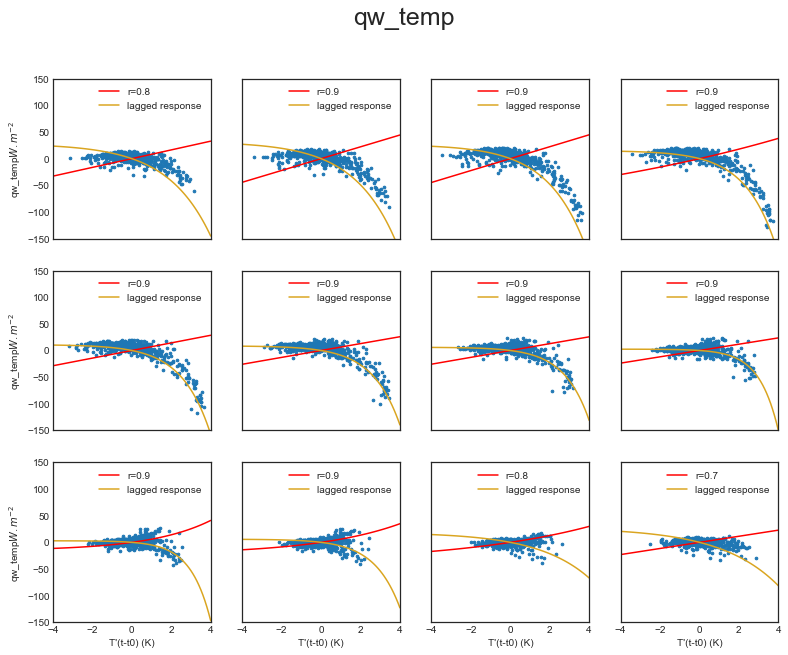

In [45]:
var_plot='qw_temp'

var1=np.reshape(heat_budget['tos'],(int(nyr/12),12))
var2=np.reshape(heat_budget[var_plot],(int(nyr/12),12))

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)
inc=0
for i in range(3):
    for j in range(4):
        monthi=inc
        monthi_lag=int((np.roll(np.linspace(0,11,12),-inc+lag))[0])
        if inc-lag < 0:  
            xdata2=np.reshape(var1[0:-1,monthi_lag],(int(nyr/12-1)))
            xdata1=np.reshape(var1[1::,monthi],(int(nyr/12-1)))
            ydata=np.reshape(var2[1::,monthi],(int(nyr/12-1)))
        else: 
            xdata2=np.reshape(var1[0::,monthi_lag],(int(nyr/12)))
            xdata1=np.reshape(var1[0::,monthi],(int(nyr/12)))
            ydata=np.reshape(var2[0::,monthi],(int(nyr/12))) 
                    
        xdata=np.stack((xdata1,xdata2),axis=0)
            
        xx1 = np.linspace(-4,4,81)
        yy1 = exp_f(xx1, Q[var_plot][inc,0],Q[var_plot][inc,1],0) - exp_f(0, Q[var_plot][inc,0],Q[var_plot][inc,1],0)
        
        xx2 = xx1
        yy2 = exp_f(xx2, Q[var_plot][inc,2],Q[var_plot][inc,3],0) - exp_f(0, Q[var_plot][inc,2],Q[var_plot][inc,3],0)
        
        axes[i][j].scatter(xdata2,ydata,s=7)
        axes[i][j].plot(xx1,yy1,color='red',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].plot(xx2,yy2,color='goldenrod',label='lagged response')
        
        
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t-t0) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

In [33]:
NN=960
Temp=np.linspace(-2.5,2.5,NN-1)

var_name   = ['qu','qv','qw','qnet','qres']
proc1      = ['_curr','_temp','_nl']
proc2      = ['']

inc=0 
for vname in var_name:
    
    if vname == 'qnet' or vname == 'qres':
        proc=proc2
    else:
        proc=proc1

    for pr in proc: 
        
        varname=vname+pr         
        condition=(varname == 'qw_temp' or varname == 'qu_curr')
            
        if not condition:
            Q[varname+'f'] = [ exp_f(Temp, *Q[varname][j,:]) - exp_f(Temp, *Q[varname][j,:])[int(NN/2)-1] for j in range(12)]
            Q[varname+'f'] =  Q[varname+'f']/ (1000 * 4000. * (heat_budget['mld']+10)) *(30*24*60*60)
        else: 
            Q[varname+'f1'] = [ exp_f(Temp, Q[varname][j,0],Q[varname][j,1],0) - exp_f(Temp, Q[varname][j,0],Q[varname][j,1],0)[int(NN/2)-1] for j in range(12)]
            Q[varname+'f1'] =  Q[varname+'f1']/ (1000 * 4000. * (heat_budget['mld']+10)) *(30*24*60*60)

            Q[varname+'f2'] = [ exp_f(Temp, Q[varname][j,2],Q[varname][j,3],0) - exp_f(Temp, Q[varname][j,2],Q[varname][j,3],0)[int(NN/2)-1] for j in range(12)]
            Q[varname+'f2'] =  Q[varname+'f2']/ (1000 * 4000. * (heat_budget['mld']+10)) *(30*24*60*60)

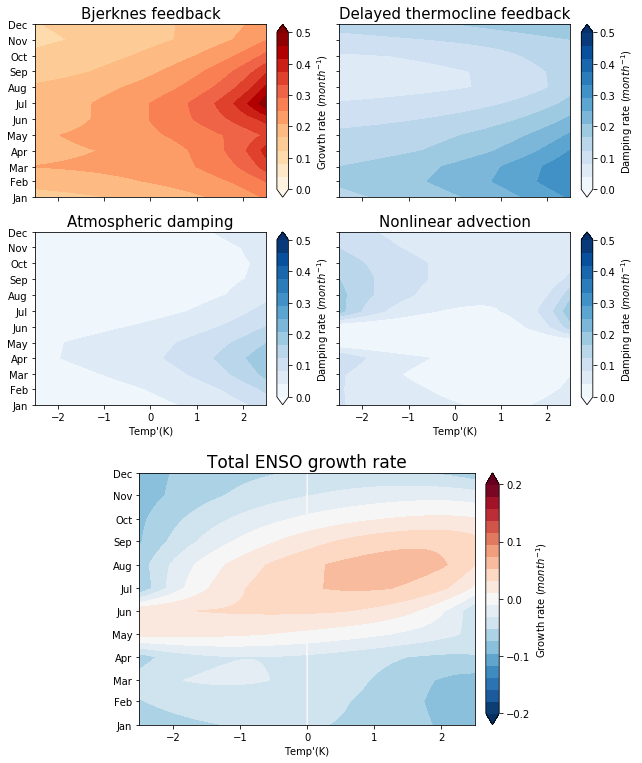

In [34]:
# Computation of the different feedbacks
Bjerknes_f  =  (Q['qu_currf1']+Q['qw_tempf1']+Q['qv_currf']+Q['qv_tempf']+Q['qu_tempf']+Q['qw_currf']) /Temp
atm_damping = -(Q['qnetf']) /Temp
nl_damping  = -(Q['qu_nlf']+Q['qv_nlf']+Q['qw_nlf']+Q['qresf']) /Temp  
del_damping = -(Q['qw_tempf2']+Q['qu_currf2']) /Temp 


growth_tot=np.zeros((12,len(Temp)))
for mo in range(12):
    for T in range(len(Temp)): 
        func = lambda sig : sig + del_damping[mo,T] * np.exp(- sig * (-lag)) + atm_damping[mo,T] + nl_damping[mo,T]- Bjerknes_f[mo,T]
        growth_tot[mo,T] = fsolve(func, 0)
        
# Set up Y-axis time
years = [datetime(2018, i+1, 1) for i in range(12)]
name_feed=['Bjerknes_f','del_damping','atm_damping','nl_damping']
subtitle =['Bjerknes feedback','Delayed thermocline feedback',\
          'Atmospheric damping','Nonlinear advection']
cb_label=[r'Growth rate ($month^{-1}$)',r'Damping rate ($month^{-1}$)',r'Damping rate ($month^{-1}$)',r'Damping rate ($month^{-1}$)']
cmaps    =['OrRd','Blues','Blues','Blues']

p, ncol, nrow, vmin, vmax, Nlev, fmt={}, 2, 2, 0, 0.5, 13, mdates.DateFormatter('%b')


fig, axs = plt.subplots(nrow, ncol, figsize=(10,7), sharey=True, sharex=True)

inc=0
for i in range(nrow):
    for j in range(ncol):
        p[inc] = axs[i][j].contourf(Temp,years,eval(name_feed[inc]),levels=np.linspace(vmin, vmax, Nlev)\
                                    ,cmap=cmaps[inc],extend='both')
        
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes("right", size="5%", pad=0.15)
        plt.colorbar(p[inc],cax=cax,ticks=mticker.MultipleLocator(0.1),label=cb_label[inc])
        axs[i][j].set_title(subtitle[inc],fontsize=15)
        axs[i][j].yaxis.set_major_formatter(fmt)
        
        if i ==1 :
            axs[i][j].set_xlabel("Temp'(K)")
        inc=inc+1
        
        
ax2 = fig.add_axes([0.27, -0.51, 0.5, 0.5])
p2=ax2.contourf(Temp,years,growth_tot,levels=np.linspace(-0.2, 0.2, 20),cmap='RdBu_r',extend='both')
ax2.yaxis.set_major_formatter(fmt)
ax2.set_xlabel("Temp'(K)")
ax2.set_title('Total ENSO growth rate',fontsize=17)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.15)
plt.colorbar(p2,cax=cax,ticks=mticker.MultipleLocator(0.1),label=r'Growth rate ($month^{-1}$)')


plt.show()

## 3. Running the NDO

After computing the growth and damping rate a,b,c and d, we approximate the SST tendency of equation (1) by a forward finite difference such as : 

$$T^{n+1}-T^{n}=aT^{n}-bT^{n-t_0}-cT^{n}-dT^{n}+N$$

In [35]:
# Number of years and member of the experiment 
nyears     = int(len(heat_budget['tos'])/12)
nmember = 10

# Set up some initial conditions 
T_init=heat_budget['tos'][0:13]
T_ndo =np.zeros((nmember,nyears*12))
Growth_ndo =np.zeros((nmember,nyears*12))

print('Computation member n°: ',end=' '),
for member in range(nmember): 
    print(member+1,end=',')
    inc=0 
    for year in range(nyears):
        for month in range(12):

            # initialize the SST
            if inc == 0: 
                T=T_init

            # Convertion to W.m-2 to K.month-1 (rho*cp*H / nday_month*nhour_day*nmin_hour*nsec_min)
            rcp=(1000 * 4000. * heat_budget['mld']) / (30*24*60*60)

            # Breaks for feedback computation to avoid biases in the extremes
            if T[-1]>heat_budget['tos'].max() : 
                Tu=heat_budget['tos'].max()
            elif T[-1] <heat_budget['tos'].min():
                Tu=heat_budget['tos'].min()
            else:
                Tu=T[-1]
             
            # Bjerknes feedback 
            A1=(exp_f(Tu, Q['qu_curr'][month,0],Q['qu_curr'][month,1],0)-exp_f(0, Q['qu_curr'][month,0],Q['qu_curr'][month,1],0))
            A2=(exp_f(Tu, Q['qw_temp'][month,0],Q['qw_temp'][month,1],0)-exp_f(0, Q['qw_temp'][month,0],Q['qw_temp'][month,1],0))
            A3=(exp_f(Tu, *Q['qv_curr'][month,:])-exp_f(0, *Q['qv_curr'][month,:]))
            A4=(exp_f(Tu, *Q['qv_temp'][month,:])-exp_f(0, *Q['qv_temp'][month,:]))
            A5=(exp_f(Tu, *Q['qu_temp'][month,:])-exp_f(0, *Q['qu_temp'][month,:]))
            A6=(exp_f(Tu, *Q['qw_curr'][month,:])-exp_f(0, *Q['qw_curr'][month,:])) 
            A=(A1+A2+A3+A4+A5+A6)/rcp
            
            # Delayed negative feedback 
            B1= exp_f(T[-lag-1], Q['qu_curr'][month,2],Q['qu_curr'][month,3],0)-exp_f(0, Q['qu_curr'][month,2],Q['qu_curr'][month,3],0)
            B2= exp_f(T[-lag-1], Q['qw_temp'][month,2],Q['qw_temp'][month,3],0)-exp_f(0, Q['qw_temp'][month,2],Q['qw_temp'][month,3],0)
            B=(B1+B2)/ rcp
                
            # Atmospheric damping 
            C=(exp_f(Tu, *Q['qnet'][month,:])-exp_f(0, *Q['qnet'][month,:])) / rcp

            # Non-linear negative feedback 
            D1=exp_f(Tu, *Q['qu_nl'][month,:])-exp_f(0, *Q['qu_nl'][month,:])
            D2=exp_f(Tu, *Q['qv_nl'][month,:])-exp_f(0, *Q['qv_nl'][month,:])
            D3=exp_f(Tu, *Q['qw_nl'][month,:])-exp_f(0, *Q['qw_nl'][month,:])
            D4=exp_f(Tu, *Q['qres'][month,:]) -exp_f(0, *Q['qres'][month,: ])
                
            D=(D1+D2+D3+D4) / rcp 
            
            # Noise, slightly skewed toward positive values 
            N = skewnorm.rvs(ska,loc=skl, size=1)*N0
      
            # Computation T_n+1 (first order forward finite difference scheme)     
            Tnp1= (A + C + D) + B + N + T[-1]

            # SST breaks to prevent the model to crash 
            if  (Tnp1) >heat_budget['tos'].max()+0.5:
                Tnp1=heat_budget['tos'].max()+0.5
            if  (Tnp1) <heat_budget['tos'].min()-0.5:
                Tnp1=heat_budget['tos'].min()-0.5
                
            # We update the T array with Tnp1 
            T= np.append(T,Tnp1) 

            inc=inc+1
        
    
    T_ndo[member,:]=T[12:-1]

Computation member n°:  1,2,3,4,5,6,7,8,9,10,

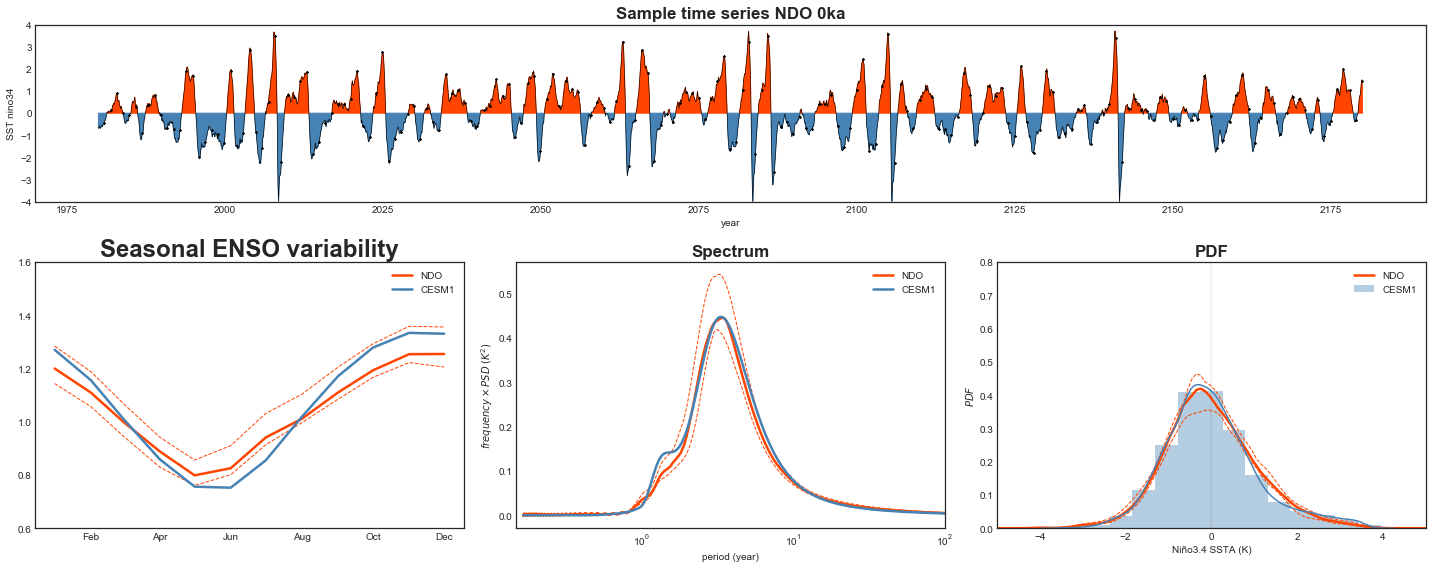

In [38]:
fig=plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(2, 3,height_ratios=[1, 1.5])

# 5 month running mean 
T_ndo=T_ndo[~np.isnan(np.nanmean(T_ndo,axis=1)),:]
nmember=nm=len(np.squeeze(np.where(~np.isnan(np.nanmean(T_ndo,axis=1)) == True)))
# T_ndo_smooth=pd.rolling_mean(T_ndo, 1,center=True,axis=1)
T_ndo_smooth=T_ndo

# ----------------------   First plot time_series ----------------------
ax1 = plt.subplot(gs[0:3])


# nb years to display 
nyr_plot=200

# We pick one member to plot
T_plot=T_ndo_smooth[0,:].squeeze()  

# creation time axis 
ti=np.linspace(0,nyr_plot-1/12,len(T_plot[0:nyr_plot*12]))

ax1.plot((ti+1980),T_plot[0:nyr_plot*12],color='k',linewidth=0.59)
ax1.plot((ti+1980)[11::12],T_plot[0:nyr_plot*12][11::12],color='k',marker='*',linewidth=0,markersize=2)
ax1.fill_between(ti+1980,T_plot[0:nyr_plot*12],where=T_plot[0:nyr_plot*12] >= 0,color='orangered')
ax1.fill_between(ti+1980,T_plot[0:nyr_plot*12],where=T_plot[0:nyr_plot*12] <= 0,color='steelblue')
ax1.set_ylim(-4,4)
ax1.set_xlabel('year')
ax1.set_ylabel('SST nino34')
ax1.set_title('Sample time series NDO '+CASE, fontsize='17',weight='semibold')

# -------------------   Seasonal ENSO variability  ---------------------
ax2 = plt.subplot(gs[3])

# creation time axis 
xmonth= [datetime(2018, i+1, 1) for i in range(12)]

# Compute the std.dev of CESM1 Niño3.4 for each calendar month
seas_std_cesm     = [np.std(heat_budget['tos'][i::12]) for i in range(12)]

# Compute the std.dev of each NDO member for each calendar month 
seas_std_ndo=np.zeros((nmember,12))
for member in range(nmember): 
    seas_std_ndo[member,:] = [np.nanstd(T_ndo_smooth[member,:][i::12]) for i in range(12)]

seas_std_ndo_per=np.percentile(seas_std_ndo, (0,50,100), axis=0)
ax2.plot(xmonth,seas_std_ndo_per[1,:],color='orangered',label='NDO',linewidth=2.5)
ax2.plot(xmonth,seas_std_ndo_per[0,:],color='orangered',linestyle='--',linewidth=1)
ax2.plot(xmonth,seas_std_ndo_per[2,:],color='orangered',linestyle='--',linewidth=1)
ax2.plot(xmonth,seas_std_cesm,label='CESM1',color='steelblue',linewidth=2.5)

fmt=mdates.DateFormatter('%b')
ax2.xaxis.set_major_formatter(fmt)
ax2.set_title('Seasonal ENSO variability', fontsize='24',weight='semibold')
ax2.set_ylim(0.6,1.6)
ax2.legend()


# ----------------------------   Spectrum   ----------------------------
ax3 = plt.subplot(gs[4])

psd_cesm = CORRELOGRAMPSD(heat_budget['tos'], heat_budget['tos'], lag=12*5)
f_cesm = np.linspace(-0.5, 0.5, len(psd_cesm))
psd_cesm = cshift(psd_cesm, len(psd_cesm)/2)[f_cesm >0]

for member in range(nmember): 
    psd_ndo1 = CORRELOGRAMPSD(T_ndo[member,:],T_ndo[member,:], lag=12*5)
    if member == 0:
        f_ndo = np.linspace(-0.5, 0.5, len(psd_ndo1))  
        psd_ndo=np.zeros((nmember,int(len(psd_ndo1)/2)))
        
    psd_ndo[member,:] = cshift(psd_ndo1, len(psd_ndo1)/2)[f_ndo >0]

psd_ndo_per=np.nanpercentile(psd_ndo, (0,50,100), axis=0)
   
ax3.semilogx(1./f_ndo[f_ndo >0]/12, psd_ndo_per[1,:]*f_ndo[f_ndo >0],c='orangered',linewidth=2.5,label='NDO')
ax3.semilogx(1./f_ndo[f_ndo >0]/12, psd_ndo_per[0,:]*f_ndo[f_ndo >0],c='orangered',linewidth=1,linestyle='--')
ax3.semilogx(1./f_ndo[f_ndo >0]/12, psd_ndo_per[2,:]*f_ndo[f_ndo >0],c='orangered',linewidth=1,linestyle='--')
ax3.semilogx(1./f_cesm[f_cesm >0]/12, psd_cesm*f_cesm[f_cesm >0],label='CESM1',c='steelblue',linewidth=2.5)

ax3.set_xlim(0.15,100)
ax3.set_xlabel('period (year)')
ax3.set_ylabel(r'$frequency \times PSD \; (K^{2})$')

ax3.legend()
ax3.set_title('Spectrum', fontsize='17',weight='semibold')


# ----------------------------   Distribution   ----------------------------
ax4 = plt.subplot(gs[5])

sns.set_style("white")
xloc=np.linspace(-5,5,100)


dist_ndo =np.zeros((nmember,len(xloc)))
for member in range(nmember): 
    dist=sns.distplot(T_ndo_smooth[member,:],hist=False,kde_kws={'alpha': 0},ax=ax4).get_lines()[member].get_data()
    inter=interp1d(dist[0], dist[1],fill_value='extrapolate')
    dist_ndo[member,:]=inter(xloc)
    
dist_ndo_per=np.percentile(dist_ndo, (0,50,100), axis=0)
ax4.plot(xloc,dist_ndo_per[1,:],color='orangered',linewidth=2.5,label='NDO')
ax4.plot(xloc,dist_ndo_per[0,:],color='orangered',linewidth=1,linestyle='--')
ax4.plot(xloc,dist_ndo_per[2,:],color='orangered',linewidth=1,linestyle='--')
ax4.plot([0,0],[0,1],color='k',linewidth=0.1)
sns.distplot(heat_budget['tos'], hist=True,kde=True,hist_kws={'alpha': 0.4},label='CESM1',norm_hist=True,bins=np.linspace(-5,5,20),ax=ax4,color='steelblue')

ax4.set_title('PDF', fontsize='17',weight='semibold')
ax4.set_xlim(-5,5)
ax4.set_ylim(0,0.8)
ax4.set_xlabel('Niño3.4 SSTA (K)')
ax4.set_ylabel(r'$PDF$')

ax4.legend()

plt.tight_layout()
plt.show()

In [39]:
js = """ <script type='text/javascript' src='https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js'></script> """ 
display(HTML(js))